In [1]:
import numpy as np
import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv
from theano.tensor.nnet import conv2d
from six.moves import cPickle
#data from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
#DCGAN architecture: https://arxiv.org/pdf/1511.06434.pdf

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
from PIL import Image
from glob import glob

In [3]:
image_list = map(lambda x: x.resize((64,64)),
                 map(Image.open, glob("../data/img_align_celeba/1*.jpg")))
image_array = np.array(list(map(np.asarray, image_list)))

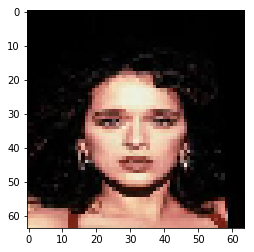

In [4]:
plt.imshow(image_array[0])

In [32]:
def rescale(x, old=[0,255], new=[-1,1], invert = False):
    if invert:
        temp = old
        old = new
        new = temp
        
    return (x - old[0])/(old[1] - old[0]) * (new[1] -new[0]) + new[0]

In [33]:
def shared_dataset(x):
    #http://deeplearning.net/tutorial/gettingstarted.html
    shared_x = theano.shared(np.asarray(x, 
                                        dtype=theano.config.floatX),
                             borrow=True)
    return shared_x

In [34]:
def deconv(X, w, subsample=(1, 1), border_mode=(0, 0), conv_mode='conv'):
    #https://github.com/Newmu/dcgan_code/lib/ops.py
    from theano.sandbox.cuda.basic_ops import (gpu_contiguous, gpu_alloc_empty)
    from theano.sandbox.cuda.dnn import GpuDnnConvDesc, GpuDnnConvGradI
    """ 
    sets up dummy convolutional forward pass and uses its grad as deconv
    currently only tested/working with same padding
    """
    img = gpu_contiguous(X)
    kerns = gpu_contiguous(w)
    desc = GpuDnnConvDesc(border_mode=border_mode, subsample=subsample,
                          conv_mode=conv_mode)(gpu_alloc_empty(img.shape[0], kerns.shape[1], img.shape[2]*subsample[0], img.shape[3]*subsample[1]).shape, kerns.shape)
    out = gpu_alloc_empty(img.shape[0], kerns.shape[1], img.shape[2]*subsample[0], img.shape[3]*subsample[1])
    d_img = GpuDnnConvGradI()(kerns, img, out, desc)
    return d_img

In [35]:
def lrelu(x, leak=0.2):
    #https://github.com/bamos/dcgan-completion.tensorflow/blob/master/ops.py
    return(T.nnet.relu(x, alpha=leak))

In [36]:
def batchnorm(X, g=None, b=None, u=None, s=None, a=1., e=1e-8):
    """
    batchnorm with support for not using scale and shift parameters
    as well as inference values (u and s) and partial batchnorm (via a)
    will detect and use convolutional or fully connected version
    """
    if X.ndim == 4:
        if u is not None and s is not None:
            b_u = u.dimshuffle('x', 0, 'x', 'x')
            b_s = s.dimshuffle('x', 0, 'x', 'x')
        else:
            b_u = T.mean(X, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
            b_s = T.mean(T.sqr(X - b_u), axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        if a != 1:
            b_u = (1. - a)*0. + a*b_u
            b_s = (1. - a)*1. + a*b_s
        X = (X - b_u) / T.sqrt(b_s + e)
        if g is not None and b is not None:
            X = X*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')
    elif X.ndim == 2:
        if u is None and s is None:
            u = T.mean(X, axis=0)
            s = T.mean(T.sqr(X - u), axis=0)
        if a != 1:
            u = (1. - a)*0. + a*u
            s = (1. - a)*1. + a*s
        X = (X - u) / T.sqrt(s + e)
        if g is not None and b is not None:
            X = X*g + b
    else:
        raise NotImplementedError
    return X

In [37]:
class ConvLayer(object):
    #https://github.com/mikesj-public/dcgan-autoencoder
    #Output must be an integer multiple of input, please use powers of 2
    def __init__(self, input,
                 input_size, output_size, 
                 num_input_filters, num_output_filters, 
                 W = None, filter_size = 5, 
                 activation = None,
                 rng = np.random.RandomState()):
        self.input = input
        
        is_deconv = output_size >= input_size

        #Size of 4d convolution tensor
        w_size = np.array([num_input_filters, num_output_filters, filter_size, filter_size]) \
                if is_deconv \
                else np.array([num_output_filters, num_input_filters, filter_size, filter_size])
        #Initialize weights
        if W == None:
            wrange = np.sqrt(6. / (np.prod(w_size[[0, 2, 3]]) + np.prod(w_size[[1, 2, 3]])))
            W_values = np.asarray(
                rng.uniform(
                    low=-wrange,
                    high=wrange,
                    size=(w_size)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=W_values, name='W', borrow=True)
        self.W = W
        
        conv_method = deconv if is_deconv else conv2d
        if activation is None: 
            activation = T.nnet.relu if is_deconv else lrelu

        #Size of subsampling
        sub = output_size / input_size \
            if is_deconv else input_size / output_size
        sub = int(sub)
        #Border size
        if filter_size == 3:
            bm = 1
        else:
            bm = 2
            
        #Output
        lin_output = conv_method(input, W, subsample=(sub, sub), border_mode=(bm, bm))
        output = activation(lin_output)
        self.output = output
        
        #Model parameters
        self.params = [self.W] 

In [38]:
class FullyConnected(object):
    #http://deeplearning.net/tutorial/mlp.html
    def __init__(self, rng, input, n_in, n_out, W = None, b = None,
                 activation = T.nnet.sigmoid):
        
        self.input = input
        
        if W is None:
            W_values = np.asarray(
                rng.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)
        else: self.W = W

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)
        else: self.b = b

        self.W = W
        self.b = b
        
        # parameters of the model
        self.params = [self.W, self.b]
        
        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )

In [ ]:
class Generator(object):
    #https://arxiv.org/pdf/1511.06434.pdf
    def __init__(self, input, params = None, 
                 rng = np.random.RandomState()):
        self.input = input
        
        project_input = input
        
        projectReshape = FullyConnected(
            rng=rng,
            activation = T.nnet.relu,
            input=batchnorm(project_input),
            n_in=100,
            n_out=4*4*1024,
            W = params[0] if params is not None else None,
            b = params[1] if params is not None else None
        )
        
        conv1_in = projectReshape.output.reshape((input.shape[0],1024,4,4))
        
        conv1 = ConvLayer(batchnorm(conv1_in), 4, 8, 1024, 512,
                          rng = rng,
                          W = params[2] if params is not None else None,
                          activation = T.nnet.relu
                         ) 
        conv2 = ConvLayer(batchnorm(conv1.output), 8, 16, 512, 256,
                          rng = rng,
                          W = params[3] if params is not None else None,
                          activation = T.nnet.relu
                         ) 
        conv3 = ConvLayer(batchnorm(conv2.output), 16, 32, 256, 128,
                          rng = rng,
                          W = params[4] if params is not None else None,
                          activation = T.nnet.relu
                         ) 
        conv4 = ConvLayer(conv3.output, 32, 64, 128, 3,
                          rng = rng,
                          W = params[5] if params is not None else None,
                          activation = T.tanh
                         ) 
        
        self.output = conv4.output
        self.params = projectReshape.params + conv1.params + conv2.params + \
                conv3.params + conv4.params 

In [ ]:
class Critic(object):
    #https://arxiv.org/pdf/1511.06434.pdf
    def __init__(self, input, params = None, 
                 rng = np.random.RandomState()):
        self.input = input
        
        conv1 = ConvLayer(input,64,32,3,64,
                          rng = rng,
                          W = params[0] if params is not None else None,
                          activation = lrelu
                         ) 
        conv2 = ConvLayer(batchnorm(conv1.output), 32, 16, 64, 128,
                          rng = rng,
                          W = params[1] if params is not None else None,
                          activation = lrelu
                         ) 
        conv3 = ConvLayer(batchnorm(conv2.output), 16, 8, 128, 256,
                          rng = rng,
                          W = params[2] if params is not None else None,
                          activation = lrelu
                         ) 
        conv4 = ConvLayer(batchnorm(conv3.output), 8, 4, 256, 512,
                          rng = rng,
                          W = params[3] if params is not None else None,
                          activation = lrelu
                         ) 
        fc_input = conv4.output.flatten(2)
        fc = FullyConnected(
            rng,
            input=batchnorm(fc_input),
            n_in=512*4*4,
            n_out=1,
            activation=T.nnet.sigmoid,
            W = params[4] if params is not None else None,
            b = params[5] if params is not None else None
        )
        
        self.output = fc.output
        self.params = conv1.params + conv2.params + \
                conv3.params + conv4.params + fc.params

In [51]:
def RMSprop(cost, params, lr=0.00005, rho=0.5, epsilon=1e-8, c=None):
    #Standard literature says rho=.9
    #DCGAN paper says rho = .5 (for ADAM though)
    #https://github.com/Newmu/Theano-Tutorials
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        update = p - lr * g if c is None else T.clip(p - lr * g, -c, c)
        updates.append((p, update))
    return updates

In [42]:
def gradDesc(cost, params, lr=.00005, c = None):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        update = p - lr * g if c is None else T.clip(p - lr * g, -c, c)
        updates.append((p, update))
    return updates

In [43]:
class DCGAN(object):
    def __init__(self,
                 genParams = None, critParams = None,
                 rng = np.random.RandomState(),
                ):
        self.rng = rng
        self.genParams = genParams
        self.critParams = critParams
        
        self.critLosses = []
        self.genLosses = []
        
        
    def train(self, X, iters = 600000,
              alpha = .00005, c = .01,
              m = 64, ncrit = 5,
              verbose = False, runningSave = False,
              runningFile="Running Save/DCGAN"):
        
        print("Building model...")
        
        # allocate symbolic variables for the data
        z = T.matrix('z')  
        x = T.tensor4('x')
        
        #Generator setup
        gen = Generator(z, params=self.genParams, rng=self.rng)
        self.gen = gen
        self.genParams = gen.params
        
        #Critic setup
        critTarget = Critic(x, params=self.critParams, rng=self.rng)
        self.critTarget = critTarget
        #critTrue params must be the same as critG params
        critG = Critic(gen.output, params=critTarget.params, rng=self.rng)
        self.critG = critG
        self.critParams = critTarget.params
        
        #Generator optimization
        genLoss = T.mean(T.log(1-critG.output))
        genParams = self.genParams
        genUpdates = RMSprop(genLoss, genParams, lr=alpha)
        #genUpdates = gradDesc(genLoss, genParams, lr=alpha)
        
        trainGen = theano.function(
            inputs = [],
            outputs = genLoss,
            updates = genUpdates,
            givens = {
                z: self.rng.uniform(low = 0, high = 1, 
                  size=(m,100)).astype(theano.config.floatX)
            }
        )
        
        #Critic optimization
        critLoss = T.mean(T.log(critTarget.output)) \
                    + T.mean(T.log(1-critG.output))
        critParams = self.critParams
        critUpdates = RMSprop(-critLoss, critParams, lr=alpha, c=c)
        #critUpdates = gradDesc(-critLoss, critParams, lr=alpha, c=c)
        
        trainCrit = theano.function(
            inputs = [],
            outputs = critLoss,
            updates = critUpdates,
            givens = {
                z: self.rng.uniform(low = 0, high = 1, 
                  size=(m,100)).astype(theano.config.floatX),
                x: X[self.rng.randint(X.shape[0].eval(), size=m)]
            }
        )
        print("Done!")
        
        print("\nBegin training...")        
        def printIter(i):
             print("Iteration %i/%i (%.2f%%)" % 
                         (
                            i+1,
                            iters,
                            100*(i+1)/iters,
                         )
                     )
                
        #Begin training
        for i in range(iters):
            #Print stuff
            isPercent = ((i+1) % (iters // 100.) == 0) if iters > 100 else True
            if i == 0 or verbose or isPercent:
                printIter(i)
            if isPercent:
                #Plot loss
                self.plot()
                #Show image
                gX = self.sample(2)
                for g in gX:
                    plt.figure()
                    plt.imshow(rescale((g.transpose(1,2,0)), invert=True).astype('uint8'))
                plt.show()
                #Save
                if runningSave:
                    self.save(runningFile + str(i+1))
                    
            for n in range(ncrit):
                critLoss = trainCrit()
                self.critLosses.append(critLoss)
            genLoss = trainGen()
            self.genLosses.append(genLoss)
        self.plot()
        
    def sample(self, n):
        Z = self.rng.uniform(low = 0, high = 1, 
                  size=(n,100)).astype(theano.config.floatX)
        
        gen = Generator(Z, params=self.genParams, rng=self.rng)
        
        return(gen.output.eval())
    
    def plot(self):
        from matplotlib import pyplot as plt
        %matplotlib inline
        plt.figure()
        plt.plot(self.critLosses)
        plt.title("Critic loss " + str(self.critLosses[-1]))
        plt.figure()
        plt.plot(self.genLosses)
        plt.title("Generator loss " + str(self.genLosses[-1]))
        plt.show()
    
    def save(self, filename="DCGAN"):
        save_file = open("../models/" + filename, 'wb')  # this will overwrite current contents
        tosave = [self.genParams, self.critParams, self.rng]
        for param in tosave:
            # the -1 is for HIGHEST_PROTOCOL
            cPickle.dump(param, save_file, -1)  
        save_file.close()
    
    def from_file(filename="DCGAN"):
        f = open("../models/" + filename, 'rb')
        genParams = cPickle.load(f)
        critParams = cPickle.load(f)
        rng = cPickle.load(f)
        clf = DCGAN(
            genParams=genParams,
            critParams=critParams,
            rng = rng,
        )
        return(clf)

In [17]:
x = image_array.transpose(0, 3, 1, 2)

In [18]:
x.shape

(100016, 3, 64, 64)

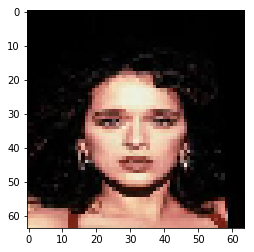

In [19]:
plt.imshow(x[0].transpose(1,2,0))

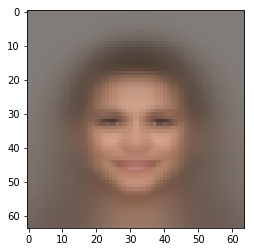

In [20]:
plt.imshow(np.mean(x, 0).transpose(1,2,0).astype('uint8'))


In [21]:
#Preprocess and make shared
X = shared_dataset(rescale(x))

In [52]:
#Initialize
dcgan = DCGAN()

Building model...
Done!

Begin training...
Iteration 1/10000 (0.01%)
Iteration 100/10000 (1.00%)


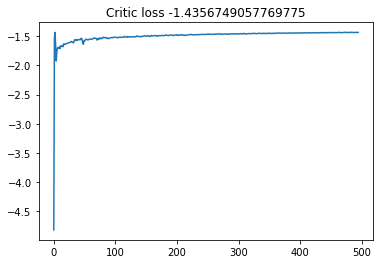

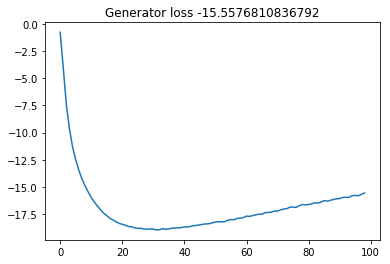

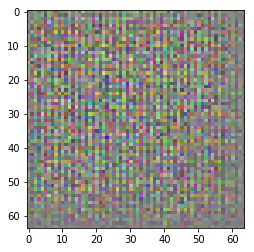

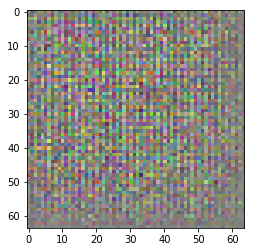

KeyboardInterrupt: 

In [53]:
#Train
dcgan.train(X, iters = 10000)
dcgan.save()

In [ ]:
dcgan.plot()

In [ ]:
dcgan.save()

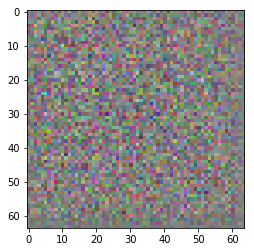

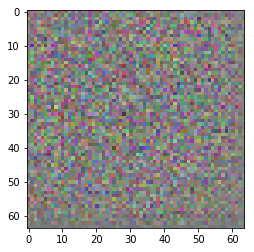

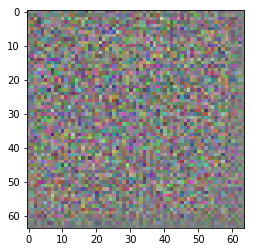

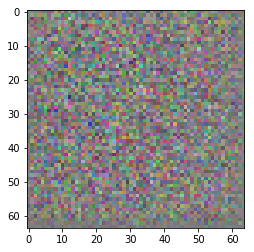

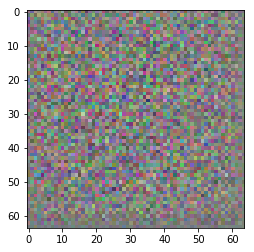

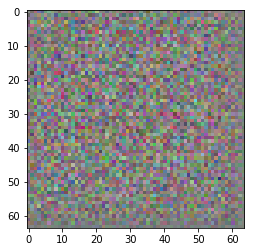

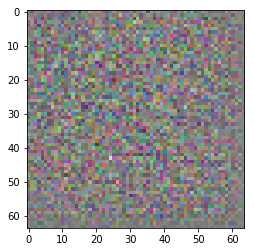

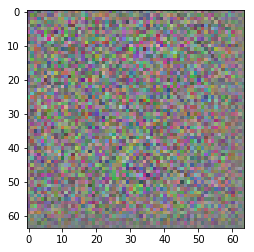

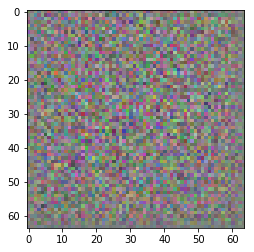

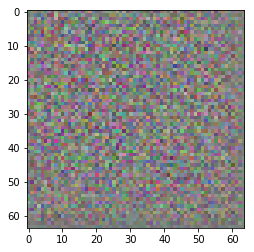

In [47]:
gX = dcgan.sample(10)
for g in gX:
    plt.figure()
    plt.imshow(rescale((g.transpose(1,2,0)), invert=True).astype('uint8'))
plt.show()